<a href="https://colab.research.google.com/github/IlyaKo4atkov/My-machine-learning-projects/blob/main/A_project_with_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Условие задачи**
## Создать модель нейронной сети, которая умеет предсказывать на кого из русских писателей похож введенный текст. Необходимо использовать публичный датасет с писателями Русской литературы, а так же загрузки слоев Embegging.

In [ ]:
!pip install keras-preprocessing

### Загрузка датасета

In [ ]:
import glob # Вспомогательный модуль для работы с файловой системой
import os
import keras
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "{data_path}" -d ./dataset

FILE_DIR_POEMS = './dataset/poems'
file_list_poems = os.listdir(FILE_DIR_POEMS)

FILE_DIR_PROSE = './dataset/prose'
file_list_prose = os.listdir(FILE_DIR_PROSE)

CLASS_LIST=['Bryusov', "Gorky", "Gogol", 'Chekhov', 'Dostoevsky', 'Turgenev']
print("Общий список писателей:")
print(CLASS_LIST)

all_texts = {} #собираем в словарь весь датасет
for author in CLASS_LIST:
  all_texts[author] = '' # Инициализация пустой строкой, нового ключа словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Замена символа перехода на новую строку пробелом

# генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in all_texts.values())
print(f'Датасет состоит из {total} символов')

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long
Общий список писателей:
['Bryusov', 'Gorky', 'Gogol', 'Chekhov', 'Dostoevsky', 'Turgenev']
Датасет состоит из 24752773 символов


### Токенизация

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

seq_train = tokenizer.texts_to_sequences(all_texts.values())


### Балансировка датасета

In [ ]:
#  генератор цикла для получения длины текстов по каждому автору
import numpy as np
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))


median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)

Датасет состоит из 3297160 слов
Общая выборка по писателям (по словам):
Bryusov - 351445 слов, доля в общей базе: 10.66%
Gorky - 557989 слов, доля в общей базе: 16.92%
Gogol - 278674 слов, доля в общей базе: 8.45%
Chekhov - 245784 слов, доля в общей базе: 7.45%
Dostoevsky - 1557021 слов, доля в общей базе: 47.22%
Turgenev - 306247 слов, доля в общей базе: 9.29%
Среднее значение слов:  549527.0
Медианное значение слов:  328846.0


In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Bryusov - 328846 слов, доля в общей базе: 18.10%
Gorky - 328846 слов, доля в общей базе: 18.10%
Gogol - 278674 слов, доля в общей базе: 15.33%
Chekhov - 245784 слов, доля в общей базе: 13.53%
Dostoevsky - 328846 слов, доля в общей базе: 18.10%
Turgenev - 306247 слов, доля в общей базе: 16.85%
Среднее значение слов:  302874.0
Медианное значение слов:  317546.5


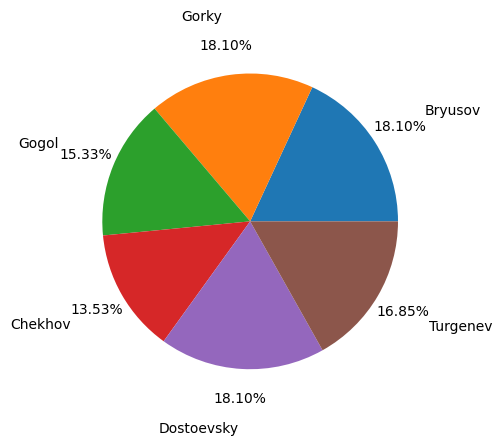

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
# использование генератора цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1817243 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Bryusov - 328846 слов, доля в общей базе: 18.10%
Gorky - 328846 слов, доля в общей базе: 18.10%
Gogol - 278674 слов, доля в общей базе: 15.33%
Chekhov - 245784 слов, доля в общей базе: 13.53%
Dostoevsky - 328846 слов, доля в общей базе: 18.10%
Turgenev - 306247 слов, доля в общей базе: 16.85%
Среднее значение слов:  302874.0
Медианное значение слов:  317546.5


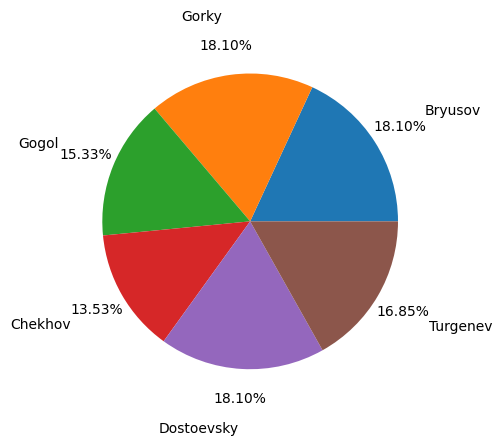

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Нарезка примеров из текста методом скользящего окна

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах
from keras.utils import get_file, to_categorical
# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую выборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получение индекса класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (16299, 1000)
Форма выходных данных (меток) для обучающей выборки: (16299, 6)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1759, 1000)
Форма выходных данных (меток) для тестовой выборки: (1759, 6)


### Функции построения графиков

In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: '+title)
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
#загрузка слоев Embegging
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

!pip install navec

from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')


--2024-10-16 00:37:35--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  57.3MB/s    in 0.9s    

2024-10-16 00:37:36 (57.3 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [ ]:
def loadEmbedding(): #функция загрузки эмбединг слоев
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

In [ ]:
#Сздание архитектуры модели
model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding()))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(32, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(250, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_MIX.layers[0].trainable = True

In [ ]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.1805 - loss: 2.1743 - val_accuracy: 0.2115 - val_loss: 1.7719
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.2226 - loss: 1.8849 - val_accuracy: 0.3366 - val_loss: 1.6062
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.3421 - loss: 1.6365 - val_accuracy: 0.4810 - val_loss: 1.2410
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.5209 - loss: 1.2493 - val_accuracy: 0.6623 - val_loss: 0.8402
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.6593 - loss: 0.9147 - val_accuracy: 0.5105 - val_loss: 1.4213
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.7524 - loss: 0.6649 - val_accuracy: 0.8994 - val_loss: 0.2723
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.9210 - loss: 0.2551 - val_accuracy: 0.9500 - val_loss: 0.1298
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.9598 - loss: 0

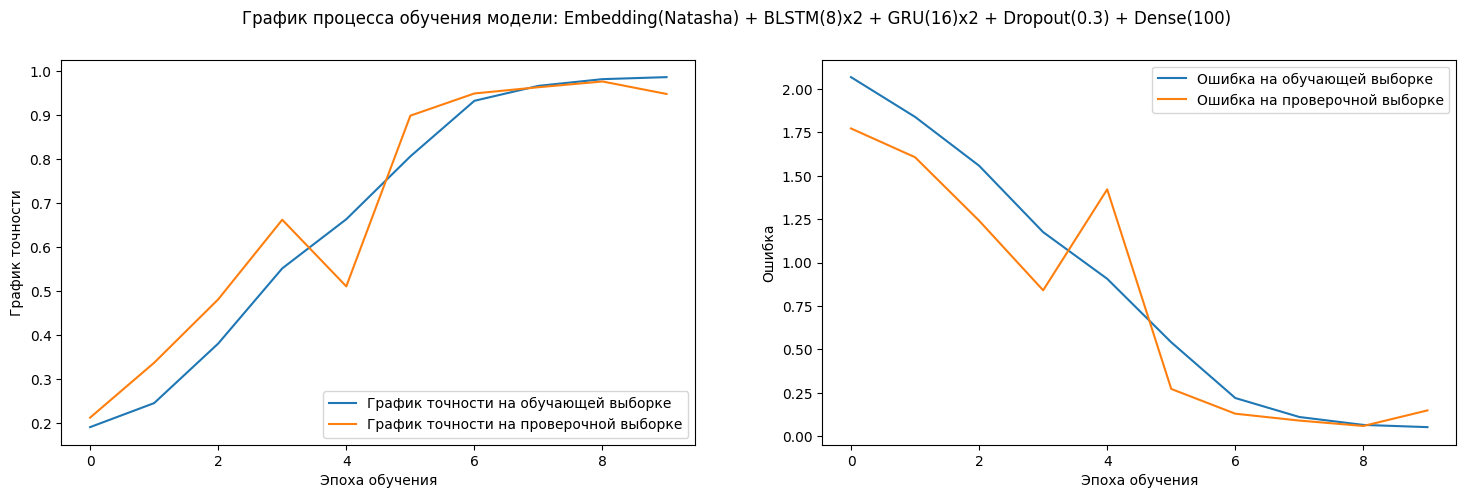

In [ ]:
show_plot(history_mix, 'Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)')

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step


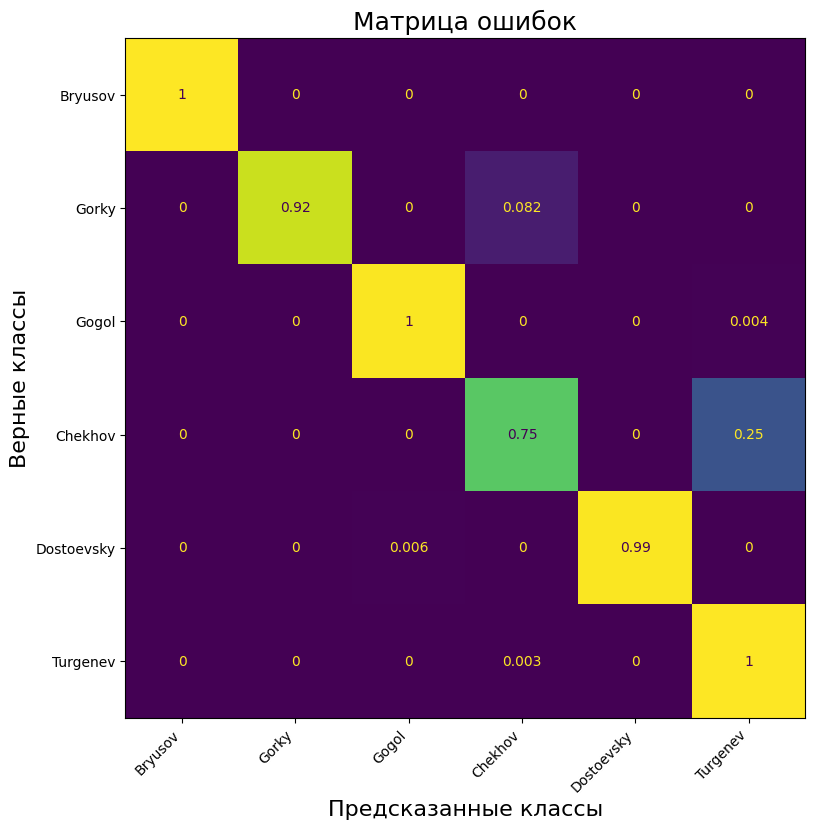


Средняя точность распознавания:  94%


In [ ]:
y_pred_mix = model_MIX.predict(x_test)
show_confusion_matrix(y_test, y_pred_mix, CLASS_LIST_BALANCE)

## При создании модели нейронной сети удалось достичь оптимальной настройки каждого слоя модели. Использование слоев Embegging, модель смогла выдать точность около 94%.